*Шишкина Марина*

Датасет, который использовался: https://www.kaggle.com/datasets/akashbommidi/super-market-sales

Импорт необходимых библиотек

In [1]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql.window import Window
from pyspark.sql.functions import udf, isnan, min, max, sum, count, desc, expr, avg
from pyspark.sql.types import IntegerType, LongType

from pyspark.ml.feature import StandardScaler, VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, GBTClassifier, LogisticRegressionModel, GBTClassificationModel, RandomForestClassificationModel

import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
import pandas as pd

In [2]:
! pip install pyspark

In [3]:
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '15G'

conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename = 'supermarket_sales.csv'
dataframe = spark.read.csv(filename, mode="DROPMALFORMED", header=True)
print('Data frame type: ' + str(type(dataframe)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


# *Обзор набора данных*




In [4]:
dataframe.show()

+-----------+------+---------+-------------+------+--------------------+----------+--------+-------+--------+---------+-----+-----------+------+-----------------------+------------+------+
| Invoice ID|Branch|     City|Customer type|Gender|        Product line|Unit price|Quantity| Tax 5%|   Total|     Date| Time|    Payment|  cogs|gross margin percentage|gross income|Rating|
+-----------+------+---------+-------------+------+--------------------+----------+--------+-------+--------+---------+-----+-----------+------+-----------------------+------------+------+
|750-67-8428|     A|   Yangon|       Member|Female|   Health and beauty|     74.69|       7|26.1415|548.9715| 1/5/2019|13:08|    Ewallet|522.83|            4.761904762|     26.1415|   9.1|
|226-31-3081|     C|Naypyitaw|       Normal|Female|Electronic access...|     15.28|       5|   3.82|   80.22| 3/8/2019|10:29|       Cash|  76.4|            4.761904762|        3.82|   9.6|
|631-41-3108|     A|   Yangon|       Normal|  Male|  Ho

In [5]:
dataframe.printSchema()
pd.DataFrame(dataframe.dtypes, columns = ['Column Name','Data type'])

root
 |-- Invoice ID: string (nullable = true)
 |-- Branch: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Customer type: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Product line: string (nullable = true)
 |-- Unit price: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- Tax 5%: string (nullable = true)
 |-- Total: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Payment: string (nullable = true)
 |-- cogs: string (nullable = true)
 |-- gross margin percentage: string (nullable = true)
 |-- gross income: string (nullable = true)
 |-- Rating: string (nullable = true)



,Column Name,Data type
0,Invoice ID,string
1,Branch,string
2,City,string
3,Customer type,string
4,Gender,string
5,Product line,string
6,Unit price,string
7,Quantity,string
8,Tax 5%,string
9,Total,string


In [7]:
dataframe = dataframe \
    .withColumn("Unit price", dataframe["Unit price"].cast(DoubleType())) \
    .withColumn("Quantity", dataframe["Quantity"].cast(IntegerType())) \
    .withColumn("Tax 5%", dataframe["Tax 5%"].cast(DoubleType())) \
    .withColumn("Total", dataframe["Total"].cast(DoubleType())) \
    .withColumn("Date", dataframe["Date"].cast(DateType())) \
    .withColumn("Time", dataframe["Time"].cast(TimestampType())) \
    .withColumn("cogs", dataframe["cogs"].cast(DoubleType())) \
    .withColumn("gross margin percentage", dataframe["gross margin percentage"].cast(DoubleType())) \
    .withColumn("gross income", dataframe["gross income"].cast(DoubleType())) \
    .withColumn("Rating", dataframe["Rating"].cast(DoubleType()))
dataframe.printSchema()
pd.DataFrame(dataframe.dtypes, columns = ['Column Name','Data type'])

root
 |-- Invoice ID: string (nullable = true)
 |-- Branch: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Customer type: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Product line: string (nullable = true)
 |-- Unit price: double (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Tax 5%: double (nullable = true)
 |-- Total: double (nullable = true)
 |-- Date: date (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Payment: string (nullable = true)
 |-- cogs: double (nullable = true)
 |-- gross margin percentage: double (nullable = true)
 |-- gross income: double (nullable = true)
 |-- Rating: double (nullable = true)



,Column Name,Data type
0,Invoice ID,string
1,Branch,string
2,City,string
3,Customer type,string
4,Gender,string
5,Product line,string
6,Unit price,double
7,Quantity,int
8,Tax 5%,double
9,Total,double


# *Поиск пропущенных значений*

In [10]:
string_columns = ['Invoice ID', 'Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Payment']
numeric_columns = ['Quantity']
missing_values = {}
for index, column in enumerate(dataframe.columns):
    if column in string_columns:
        missing_count = dataframe.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_columns:
        missing_count = dataframe.where(col(column).isin([0,None,np.nan])).count()
        missing_values.update({column:missing_count})
m_df = pd.DataFrame.from_dict([missing_values])
m_df

,Invoice ID,Branch,City,Customer type,Gender,Product line,Quantity,Payment
0,0,0,0,0,0,0,0,0


# *Визуализация распределения наиболее важных признаков*

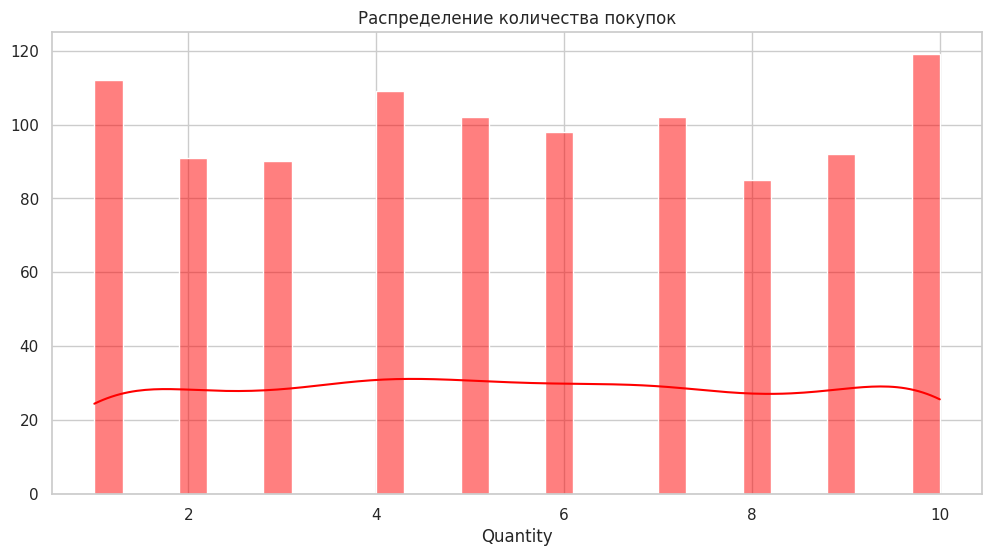

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = dataframe.select('City', 'Gender', 'Quantity').toPandas()

sns.set(style="whitegrid", color_codes=True)

plt.figure(figsize=(12, 6))
sns.histplot(df['Quantity'], bins=30, kde=True, color='red')
plt.title('Распределение количества покупок')
plt.xlabel('Quantity')
plt.ylabel('')
plt.show()

# *Несколько UDF для работы с данными*

*UDF для вычисления общего дохода:*

In [38]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, StringType

def calculate_total_income(unit_price, quantity):
    if unit_price is not None and quantity is not None:
        return unit_price * quantity
    return None

calculate_total_income_udf = udf(calculate_total_income, IntegerType())

*UDF для вычисления валовой прибыли:*

In [39]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

def calculate_gross_income(total_income, cogs):
    if total_income is not None and cogs is not None:
        return total_income - cogs
    return None

calculate_gross_income_udf = udf(calculate_gross_income, IntegerType())

*UDF для получения рейтинга на основе процента валовой прибыли:*

In [40]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def get_rating(gross_margin_percentage):
    if gross_margin_percentage is not None:
        if gross_margin_percentage >= 80:
            return "Excellent"
        elif gross_margin_percentage >= 60:
            return "Good"
        elif gross_margin_percentage >= 40:
            return "Average"
        else:
            return "Poor"
    return None

get_rating_udf = udf(get_rating, StringType())